<a href="https://colab.research.google.com/github/MarcosLaydner/ds_repo/blob/master/Assignment_2/Pump_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Enviroment preparation

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from google.colab import files
from zipfile import ZipFile
import matplotlib.pyplot as plt

!pip install -U scikit-multiflow
from skmultiflow.meta import LearnNSE

     |████████████████████████████████| 16.3MB 75.3MB/s 


In [0]:
# Install Kaggle library
!pip install -q kaggle

# Upload kaggle API key file if needed
# uploaded = files.upload()

# moves json file so the download commands works properly
# !cp kaggle.json ~/.kaggle/kaggle.json

# Or alternatively, type your credentials into the following variables
os.environ['KAGGLE_USERNAME'] = "user" # username from the json file
os.environ['KAGGLE_KEY'] = "key" # key from the json file

# Dataset download, storage and preprocessing

In [3]:
!kaggle datasets download -d nphantawee/pump-sensor-data
zip_file = ZipFile('pump-sensor-data.zip')
df = pd.read_csv(zip_file.open('sensor.csv'))

df

 27% 10.0M/37.1M [00:00<00:00, 33.9MB/s]
100% 37.1M/37.1M [00:00<00:00, 93.8MB/s]


,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.989580,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.989580,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,1.708474,420.8480,NaN,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,661.5740,721.8750,694.7721,441.2635,169.9820,343.1955,200.9694,93.90508,41.40625,31.25000,69.53125,30.468750,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221,1.579427,420.7494,NaN,462.8980,460.8858,2.509521,666.0114,399.1046,878.8917,499.0430,977.7520,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493,166.4987,343.9586,193.1689,101.04060,41.92708,31.51042,72.13541,30.468750,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,31.95202,1.683831,419.8926,NaN,461.4906,468.2206,2.604785,663.2111,400.5426,882.5874,498.5383,979.5755,627.1830,737.6033,846.9182,408.8159,785.2307,704.6937,631.4814,766.1458,702.4431,433.9081,164.7498,339.9630,193.8770,101.70380,42.70833,31.51042,76.82291,30.989580,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,220315,2018-08-31 23:55:00,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,15.16204,43.17085,54.16052,38.05424,13.265320,420.7993,NaN,463.2318,458.3615,2.499117,676.6655,405.7680,894.5920,543.5801,1109.5010,611.1745,700.5885,796.5964,692.1138,779.2067,485.0358,691.6666,974.9999,927.6135,477.3156,266.0334,578.5221,817.5707,0.00000,47.13541,29.16667,71.61458,30.468750,30.208330,38.28125,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,NaN,231.1921,NORMAL
220316,220316,2018-08-31 23:56:00,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,15.11863,43.21038,54.52602,38.53485,13.242270,422.1567,NaN,463.1928,468.4388,2.

In [0]:
def missing_data_treatment(data):
  for i in data.columns:
    if data[i].dtype == 'object':
      data[i] = data[i].fillna(data[i].mode().iloc[0])
    if (data[i].dtype == 'int' or data[i].dtype == 'float'):
      data[i] = data[i].fillna(np.mean(data[i]))

def label_encoding(data, encoder):
  for i in data.columns:
    if (data[i].dtype == 'object'):
      data[i] = encoder.fit_transform(data[i].astype('str'))
      data[i] = data[i].astype('object')

In [5]:
df = df.drop(columns=['sensor_15'])

missing_data_treatment(df)
number = LabelEncoder()
label_encoding(df, number)

train, test = train_test_split(df, shuffle=False)

test

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
165240,165240,165240,2.453588,45.876740,53.689240,45.138885,637.036987,64.82624,14.57610,16.70284,15.70457,15.16204,44.54719,51.14783,32.63393,19.29945,421.2889,464.5879,453.7494,2.459248,667.3094,400.7867,882.7717,535.7959,1095.641,627.8105,741.7908,983.1227,517.4292,1051.0540,598.4416,719.9074,985.4166,1009.5890,543.2834,370.6706,548.2872,836.0478,51.24624,52.34375,35.15625,100.26040,35.416660,35.156250,50.00000,46.29630,40.219906,54.97685,43.692130,222.5116,53.240740,183.04926,175.6366,1
165241,165241,165241,2.453588,45.876740,53.689240,45.138885,637.036987,64.82624,14.57610,16.70284,15.70457,15.16204,44.54719,51.14783,32.63393,19.29945,421.2889,464.5879,453.7494,2.459248,667.3094,400.7867,882.7717,535.7959,1095.641,627.8105,741.7908,983.1227,517.4292,1051.0540,598.4416,719.9074,985.4166,1009.5890,543.2834,370.6706,548.2872,836.0478,51.24624,52.34375,35.15625,100.26040,35.416660,35.156250,50.00000,46.29630,40.219906,54.97685,43.692130,222.5116,53.240740,183.04926,175.6366,1
165242,165242,165242,2.449653,45.963540,53.645830,45.138885,635.879639,65.98254,14.60503,16.70284,15.61777,15.16204,44.26668,52.62779,32.26524,19.32389,419.8232,458.6252,466.0694,2.588427,665.1129,399.2256,879.5967,534.7852,1089.110,630.3295,741.7555,981.1262,496.7821,1061.8190,563.2458,706.4814,1062.5000,1023.0380,577.7612,364.0239,540.9376,833.4713,47.85880,51.30208,34.89583,97.39583,35.416660,35.416660,50.78125,45.13889,40.219906,57.00232,43.692130,224.2477,53.530090,183.04926,175.3472,1
165243,165243,165243,2.459491,45.876740,53.645832,45.138885,633.217590,67.68879,14.53993,16.60880,15.61777,15.11863,44.00895,52.73262,32.25240,18.52543,420.8510,462.5743,466.6902,2.565156,665.3815,397.6859,876.1518,534.7910,1088.459,624.3346,739.8666,980.4238,488.4244,1051.0550,553.6876,690.7407,1029.1670,956.5541,539.4008,361.5701,545.2599,838.9528,41.62543,51.04166,34.11458,95.05208,35.156250,35.156250,50.00000,44.56018,40.219910,58.15972,43.981480,225.6944,53.819440,183.04926,173.9005,1
165244,165244,165244,2.449653,45.876736,53.645830,45.138885,632.407349,66.92718,14.60503,16.60880,15.69734,15.16204,44.43157,52.87685,32.08264,18.96363,420.0955,462.8652,467.5453,2.589695,663.7889,399.1443,880.2036,533.3046,1088.436,627.7715,739.6794,981.4586,471.1146,1060.1300,545.2603,655.0926,947.3958,1016.2690,555.5678,361.7527,537.9611,847.1089,60.82851,50.78125,33.85416,92.70833,35.156250,35.156250,49.47916,43.69213,40.509258,59.31713,43.981480,225.6944,53.819443,183.04926,172.7431,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,220315,220315,2.407350,47.699650,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,15.16204,43.17085,54.16052,38.05424,13.26532,420.7993,463.2318,458.3615,2.499117,676.6655,405.7680,894.5920,543.5801,1109.501,611.1745,700.5885,796.5964,692.1138,779.2067,485.0358,691.6666,974.9999,927.6135,477.3156,266.0334,578.5221,817.5707,0.00000,47.13541,29.16667,71.61458,30.468750,30.208330,38.28125,68.28703,52.372680,48.32176,41.087960,212.3843,153.645800,183.04926,231.1921,1
220316,220316,220316,2.400463,47.699650,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,15.11863,43.21038,54.52602,38.53485,13.24227,422.1567,463.1928,468.4388,2.618476,676.6547,406.2575,895.5599,541.7014,1106.371,609.4917,698.4915,800.1906,69

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


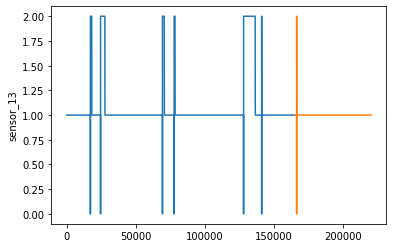

In [0]:
plt.subplot()
plt.plot( train.machine_status)
plt.ylabel('sensor_13')
plt.subplot()
plt.plot(test.machine_status)
plt.ylabel('sensor_13')
plt.show()

# Functions for checking Covariate Shift

In [0]:
def compare_train_test_distribution(train, test, col, bins):  
  N_points = 100000
  n_bins = bins

  x = train[col]
  y = test[col]

  fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

  # We can set the number of bins with the `bins` kwarg
  axs[0].hist(x, bins=n_bins)
  axs[1].hist(y, bins=n_bins)

def concat(train_df, test_df, id_column, y):
  train_df.drop(columns=[id_column, y], inplace=True)
  test_df.drop(columns=[id_column, y], inplace=True)

  train_df['is_test'] = 0
  test_df['is_test'] = 1
  df = pd.concat([train_df, test_df], axis = 0)
  return df

def shuffle_split(df):
  y = df['is_test']
  X = df.drop(columns=['is_test'])

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
  print('train2 shape:', X_train.shape, 'test2 shape:', X_test.shape)
  return X_train, X_test, y_train, y_test


def test_shift(X_train, X_test, y_train, y_test):
  rfc = RandomForestClassifier()
  rfc.fit(X_train, y_train)
  y_test_score = rfc.predict_proba(X_test)

  print('AUC score: ', round(roc_auc_score(y_true=y_test, y_score=y_test_score[:,1]), 4))

# Applying the functions to the data

train2 shape: (154224, 52) test2 shape: (66096, 52)
AUC score:  1.0


False

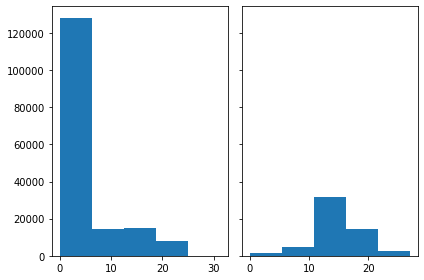

In [8]:
train_c = train.copy()
test_c = test.copy()

compare_train_test_distribution(train_c, test_c, 'sensor_13', 5)

concat_df = concat(train_c, test_c, 'Unnamed: 0', 'machine_status')
param = shuffle_split(concat_df)

test_shift(param[0], param[1], param[2], param[3])

np.any(pd.isna(train))

score of 1.0 indicating total shift

# Identifying problematic features

In [9]:
y = concat_df['is_test']
model = RandomForestClassifier(n_estimators = 50, max_depth = 5,min_samples_leaf = 5)
drop_list = []
for i in concat_df.columns:
  score = cross_val_score(model,pd.DataFrame(concat_df[i]),y,cv=2,scoring='roc_auc')
  if (np.mean(score) > 0.8):
    drop_list.append(i)
    print(i,np.mean(score))

drop_list.remove('is_test')
drop_list

sensor_06 0.9765147393716356
sensor_07 0.8110294317615871
sensor_11 0.8197349327674084
sensor_13 0.898767418602145
sensor_30 0.8036164842291849
sensor_35 0.8663917571228893
sensor_37 0.9115711466185406
sensor_46 0.8026958572570748
sensor_48 0.896410109205826
sensor_50 0.933620793996611
is_test 1.0


['sensor_06',
 'sensor_07',
 'sensor_11',
 'sensor_13',
 'sensor_30',
 'sensor_35',
 'sensor_37',
 'sensor_46',
 'sensor_48',
 'sensor_50']

# Determining the importance of the drifting features

In [0]:
missing_data_treatment(df)
number = LabelEncoder()
label_encoding(df, number)

train, test = train_test_split(df, shuffle=False)

In [0]:
rf = RandomForestClassifier()
rf.fit(train.drop('machine_status',axis=1),train['machine_status'])
pred = rf.predict(test.drop('machine_status', axis=1))

correct_predictions = 0
for i in range(len(pred)):
  if pred[i] == test.iloc[i]['machine_status']:
    correct_predictions+=1

print('The accuracy of the model with all features is {}'.format(correct_predictions / len(pred)))


The accuracy of the model with all features is 0.9989832970225128


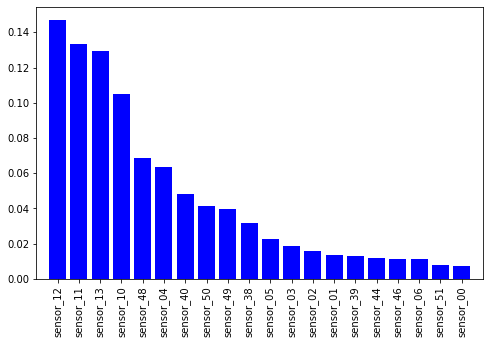

In [0]:
features = train.drop('machine_status',axis=1).columns.values
imp = rf.feature_importances_
indices = np.argsort(imp)[::-1][:20]

#plot
plt.figure(figsize=(8,5))
plt.bar(range(len(indices)), imp[indices], color = 'b', align='center')
plt.xticks(range(len(indices)), features[indices], rotation='vertical')
plt.xlim([-1,len(indices)])
plt.show()

In [0]:
non_important = drop_list[:]
non_important.remove('sensor_13')
non_important.remove('sensor_48')

This way, it is possible to conclude that sensor_13 is the only relatively important features among the drifting ones. That way, it is removed from the list of features to be dropped.

## Testing the performance without the problem features

In [0]:
def test_perfomance(dropped_features):
  drift_train = train.drop(columns=dropped_features)
  drift_test = test.drop(columns=dropped_features)

  rf = RandomForestClassifier()
  rf.fit(drift_train.drop('machine_status',axis=1),drift_train['machine_status'])
  pred = rf.predict(drift_test.drop('machine_status', axis=1))

  correct_predictions = 0
  for i in range(len(pred)):
    if pred[i] == drift_test.iloc[i]['machine_status']:
      correct_predictions+=1

  print('Score is {}'.format(correct_predictions / len(pred)))

In [0]:
print('Removed all drifting features')
test_perfomance(drop_list)
print('Removed only non-important drifting features')
test_perfomance(non_important)

Removed all drifting features
Score is 0.9990740740740741
Removed only non-important drifting features
Score is 0.9991648511256355


## Fixed LearnNSE class

Due to a bug on the current version of the LearnNSE class of scikit-multiflow, this fix has to be included in the code for it to run properly. Whenever this fix is deployed on a stable version, this code is redundant and should be deleted

In [0]:
import copy as cp
import numpy as np
from sklearn.tree import DecisionTreeClassifier

from skmultiflow.core import BaseSKMObject, ClassifierMixin, MetaEstimatorMixin

import warnings


def LearnNSE(base_estimator=DecisionTreeClassifier(), window_size=250, slope=0.5, crossing_point=10, n_estimators=15,
             pruning=None):     # pragma: no cover
    warnings.warn("'LearnNSE' has been renamed to 'LearnPPNSEClassifier' in v0.5.0.\n"
                  "The old name will be removed in v0.7.0", category=FutureWarning)
    return LearnPPNSEClassifier(base_estimator=base_estimator,
                                window_size=window_size,
                                slope=slope,
                                crossing_point=crossing_point,
                                n_estimators=n_estimators,
                                pruning=pruning)


class LearnPPNSEClassifier(BaseSKMObject, ClassifierMixin, MetaEstimatorMixin):
    """ Learn++.NSE ensemble classifier.
    Learn++.NSE [1]_ is an ensemble of classifiers for incremental learning
    from non-stationary environments (NSEs) where the underlying data
    distributions change over time. It learns from consecutive batches of data
    that experience constant or variable rate of drift, addition or deletion
    of concept classes, as well as cyclical drift.
    References
    ----------
    .. [1] Ryan Elwell and Robi Polikar. Incremental learning of concept drift in
       non-stationary environments. IEEE Transactions on Neural Networks,
       22(10):1517-1531, October 2011. ISSN 1045-9227. URL
       http://dx.doi.org/10.1109/TNN.2011.2160459
    Parameters
    ----------
    base_estimator: StreamModel or sklearn.BaseEstimator (default=DecisionTreeClassifier)
        Each member of the ensemble is an instance of the base estimator.
    n_estimators: int (default=15)
        The number of base estimators in the ensemble.
    window_size: int (default=250)
        The size of the training window (batch), in other words, how many instances are kept for training.
    crossing_point: float (default=0.5)
        Halfway crossing point of the sigmoid function controlling the number of previous
        periods taken into account during weighting.
    slope: float (default=0.5)
        Slope of the sigmoid function controlling the number
        of previous periods taken into account during weighting.
    pruning: string (default=None)
        Classifiers pruning strategy to be used.
        pruning=None: Don't prune classifiers
        pruning='age': Age-based
        pruning='error': Error-based
    Examples
    --------
    .. code-block:: python
       # Imports
       from skmultiflow.data import SEAGenerator
       from skmultiflow.meta import LearnPPNSEClassifier
       # Setup a data stream
       stream = SEAGenerator(random_state=1)
       # Setup Dynamic Weighted Majority Ensemble Classifier
       learn_pp_nse = LearnPPNSEClassifier()
       # Setup varibles to control loop and track performance
       n_samples = 0
       correct_cnt = 0
       max_samples = 200
       # Train the classifier with the samples provided by the data stream
       while n_samples < max_samples and stream.has_more_samples():
           X, y = stream.next_sample()
           y_pred = learn_pp_nse.predict(X)
           if y[0] == y_pred[0]:
               correct_cnt += 1
           learn_pp_nse = learn_pp_nse.partial_fit(X, y, classes=stream.target_values)
           n_samples += 1
       # Display results
       print('{} samples analyzed.'.format(n_samples))
       print('LearnPP.NSE accuracy: {}'.format(correct_cnt / n_samples))
    """

    def __init__(self,
                 base_estimator=DecisionTreeClassifier(),
                 window_size=250,
                 slope=0.5,
                 crossing_point=10,
                 n_estimators=15,
                 pruning=None):
        super().__init__()
        self.ensemble = []
        self.ensemble_weights = []
        self.bkts = []
        self.wkts = []
        self.buffer = []
        self.window_size = window_size
        self.slope = slope
        self.crossing_point = crossing_point
        self.n_estimators = n_estimators
        self.pruning = pruning
        self.X_batch = []
        self.y_batch = []
        self.instance_weights = []
        self.base_estimator = cp.deepcopy(base_estimator)
        self.classes = None

    @staticmethod
    def _train_model(estimator, X, y, classes=None):
        try:
            estimator.fit(X, y, classes=classes)
        except TypeError:
            try:
                estimator.fit(X, y)
            except NotImplementedError:
                estimator.partial_fit(X, y, classes=classes)

    def partial_fit(self, X, y=None, classes=None, sample_weight=None):
        """
        Partially fits the model, based on the X and y matrix.
        Parameters
        ----------
        X: numpy.ndarray of shape (n_samples, n_features)
            Features matrix used for partially updating the model.
        y: Array-like
            An array-like of all the class labels for the samples in X.
        classes: numpy.ndarray, optional (default=None)
            Array with all possible/known class labels. This is an optional parameter, except
            for the first partial_fit call where it is compulsory.
        sample_weight: NOT used (default=None)
        Raises
        ------
        RuntimeError:
            A RuntimeError is raised if the 'classes' parameter is not
            passed in the first partial_fit call, or if they are passed in further
            calls but differ from the initial classes list passed.
            A RuntimeError is raised if the base_estimator is too weak. In other word,
            it has too low accuracy on the dataset.
        Returns
        -------
        LearnPPNSEClassifier
            self
        """

        N, _ = X.shape
        if self.classes is None:
            if classes is None:
                raise RuntimeError("Should pass the classes in the first partial_fit call")
            else:
                self.classes = classes

        for i in range(N):
            self.X_batch.append(X[i])
            self.y_batch.append(y[i])
            mt = len(self.y_batch)

            if mt == self.window_size:
                self.X_batch = np.array(self.X_batch)
                self.y_batch = np.array(self.y_batch)

                classifier = cp.deepcopy(self.base_estimator)

                if len(self.ensemble) > 0:
                    # Compute the error of the existing ensemble on the new data
                    votes = self.predict(self.X_batch)

                    et = np.sum(votes != self.y_batch) / mt

                    # Update and normalize instance weights
                    self.instance_weights = np.ones(mt) / mt
                    self.instance_weights[votes == self.y_batch] = et / mt

                    # normalize instance weights (distribution)
                    sum_weights = np.sum(self.instance_weights)
                    if sum_weights > 0:
                        self.instance_weights = self.instance_weights / sum_weights

                    # Train base classifier with Dt
                    self._train_model(classifier, self.X_batch, self.y_batch, classes=self.classes)

                else:
                    # First run! train the classifier on the instances with the same weight
                    self.instance_weights = np.ones(mt) / mt

                    self._train_model(classifier, self.X_batch, self.y_batch, classes=self.classes)

                self.ensemble.append(classifier)
                self.bkts.append([])
                self.wkts.append([])
                self.ensemble_weights = []

                t = len(self.ensemble)
                max_error = -np.inf
                error_index = -1

                # Evaluate all existing classifiers on the new dataset
                for k in range(1, t + 1):
                    pred = self.ensemble[k - 1].predict(self.X_batch)
                    ekt = np.sum(self.instance_weights[pred != self.y_batch])

                    if k == t and ekt > 0.5:
                        # Generate a new classifier
                        classifier = cp.deepcopy(self.base_estimator)
                        self._train_model(classifier, self.X_batch, self.y_batch, classes=self.classes)
                        self.ensemble[k - 1] = classifier
                    elif ekt > 0.5:
                        ekt = 0.5

                    # Storing the index of the classifier with higher error in case of error-based pruning
                    if ekt > max_error:
                        max_error = ekt
                        error_index = k

                    # Normalize errors
                    bkt = ekt / (1 - ekt)

                    # store normalized error for this classifier
                    nbkts = self.bkts[k - 1]
                    nbkts.append(bkt)

                    # compute the weighted normalized errors for kth classifier h_k
                    wkt = 1.0 / (1.0 + np.exp(-self.slope * (t - k - self.crossing_point)))
                    weights = self.wkts[k - 1]
                    weights.append(wkt / (np.sum(weights) + wkt))

                    sbkt = np.sum(np.array(nbkts) * np.array(weights)) + 1e-50

                    # Calculate classifier voting weights
                    self.ensemble_weights.append(np.log(1.0 / sbkt))

                # Ensemble pruning

                if self.pruning == 'age' and t > self.n_estimators:
                    # Age-based
                    self.ensemble.pop(0)
                    self.ensemble_weights.pop(0)
                    self.bkts.pop(0)
                    self.wkts.pop(0)
                elif self.pruning == 'error' and t > self.n_estimators:
                    # Error-based
                    self.ensemble.pop(error_index - 1)
                    self.ensemble_weights.pop(error_index - 1)
                    self.bkts.pop(error_index - 1)
                    self.wkts.pop(error_index - 1)

                # Reset the buffer
                self.X_batch = []
                self.y_batch = []
        return self

    def __vote_proba(self, X, t, classes):
        res = []
        for m in range(len(X)):
            votes = np.zeros((1, len(classes)))
            for i in range(t):
                if self.ensemble_weights[i] > 0:
                    h = self.ensemble[i]
                    y_predicts = h.predict_proba(X[m].reshape(1, -1))
                    y_predicts /= np.linalg.norm(y_predicts, ord=1, axis=1, keepdims=True)
                    try:
                        votes += self.ensemble_weights[i] * y_predicts
                    except ValueError:
                        if hasattr(h, 'classes_'):  # sklearn learner
                            obs_classes = h.classes_
                        elif hasattr(h, 'classes'):  # skmultiflow learner
                            obs_classes = h.classes
                        else:
                            raise AttributeError(
                                'The base estimator does not define the "classes" or "classes_" ' +
                                'parameter. The base estimator must specify the classes it has ' +
                                'observed during the training stage in order to maintain ' +
                                'consistency across the ensemble.'
                            )
                        votes += self.ensemble_weights[i] * \
                            self._fill_missing_probs(
                                y_predicts, obs_classes, self.classes
                            )

            res.append(votes.reshape(len(classes)))
        return np.array(res)

    def _fill_missing_probs(self, probs, obs_classes, all_classes):
        proba_ordered = np.zeros(
            (probs.shape[0], len(all_classes)), dtype=np.float
        )
        sorted_classes = np.argsort(all_classes)
        # Find positions to insert existing classes' probs to the complete set
        # of classes
        idx = sorted_classes[np.searchsorted(all_classes, obs_classes, sorter=sorted_classes)]
        proba_ordered[:, idx] = probs
        return proba_ordered

    def predict_proba(self, X):
        """ Predicts the probability of each sample belonging to each one of the
        known classes.
        Parameters
        ----------
        X: numpy.ndarray of shape (n_samples, n_features)
            A matrix of the samples we want to predict.
        Returns
        -------
        numpy.ndarray
            An array of shape (n_samples, n_features), in which each outer entry is
            associated with the X entry of the same index. And where the list in
            index [i] contains len(self.target_values) elements, each of which represents
            the probability that the i-th sample of X belongs to a certain label.
        """

        if not self.ensemble:
            return np.zeros((len(X), 1))

        return self.__vote_proba(X, len(self.ensemble), self.classes)

    def predict(self, X):
        """ Predicts the class for a given sample by majority vote from all
        the members of the ensemble.
        Parameters
        ----------
        X: numpy.ndarray of shape (n_samples, n_features)
            A matrix of the samples we want to predict.
        Returns
        -------
        numpy.ndarray
            A numpy.ndarray with the label prediction for all the samples in X.
        """

        votes = self.predict_proba(X)
        return np.argmax(votes, axis=1)

    def reset(self):
        self.ensemble = []
        self.ensemble_weights = []
        self.bkts = []
        self.wkts = []
        self.X_batch = []
        self.y_batch = []

## Testing the perfomance of Learn++.NSE, with and without drifting features

In [0]:
def learn_nse_method(train_df):
  learn_nse = LearnNSE()

  n_samples = 0
  correct_cnt = 0

  for i in range(len(train_df)):
    sample = train_df.iloc[[i]]
    X = sample.drop('machine_status',axis=1)
    y = sample['machine_status']
    
    y_pred = learn_nse.predict(X.to_numpy())

    if y.values[0] == y_pred[0]:
      correct_cnt += 1

    learn_nse = learn_nse.partial_fit(X.to_numpy(), y.to_numpy(), classes=[0, 1, 3])
    n_samples += 1
  
  print('{} samples analyzed.'.format(n_samples))
  print('LearnPP.NSE accuracy: {}'.format(correct_cnt / n_samples))

  return learn_nse

In [12]:
learn_nse = learn_nse_method(train)

pred = learn_nse.predict(test.drop('machine_status',axis=1).to_numpy())

correct_predictions = 0
for i in range(len(pred)):
  if pred[i] == test.iloc[i]['machine_status']:
    correct_predictions+=1

print('Score is {}'.format(correct_predictions / len(pred)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: 'LearnNSE' has been renamed to 'LearnPPNSEClassifier' in v0.5.0.
The old name will be removed in v0.7.0
  del sys.path[0]


165240 samples analyzed.
LearnPP.NSE accuracy: 0.8813725490196078
Score is 0.9986201888162672


Using Learn++.NSE without drifting feature


In [0]:
drift_train = train.drop(columns=non_important)
drift_test = test.drop(columns=non_important)

learn_nse = learn_nse_method(drift_train)

pred = learn_nse.predict(test.drop('machine_status',axis=1).to_numpy())

correct_predictions = 0
for i in range(len(pred)):
  if pred[i] == drift_test.iloc[i]['machine_status']:
    correct_predictions+=1

print('Score is {}'.format(correct_predictions / len(pred)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: 'LearnNSE' has been renamed to 'LearnPPNSEClassifier' in v0.5.0.
The old name will be removed in v0.7.0
  del sys.path[0]


165240 samples analyzed.
LearnPP.NSE accuracy: 0.8860869038973614
Score is 0.9986201888162672
